## 1- importer les bibliothéques

In [1]:
import os
from PIL import Image
import numpy as np 
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.utils import resample
from keras.models import load_model
from scipy import stats
from matplotlib.ticker import MultipleLocator as Ml
from matplotlib.ticker import ScalarFormatter as SF


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2- fixer les path des données

In [2]:

path_model="/kaggle/input/bootstrap-data/ModelSjogrenn(2).h5"
sj_fliped='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_fliped'
sj_zoom='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_zoom'
sj_rotation='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_rotation'
sj_translation='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_translation'
sj_distortion='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_distortion'
sj_rot_trans_flip='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_fliped_rotation_translation'
sj_flip_distortion='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_fliped_distortion'
sj_rot_tran='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_rotation_translation'

nsj_fliped='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_fliped'
nsj_zoom='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_zoom'
nsj_rotation='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_rotation'
nsj_translation='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_translation'
nsj_distortion='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_distortion'
nsj_rot_trans_flip='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_fliped_rotation_translation'
nsj_flip_distortion='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_fliped_distortion'
nsj_rot_tran='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_rotation_translation'

sj_path='/kaggle/input/sjdata/DATA_(512,512)/sj_data'
nsj_path='/kaggle/input/sjdata/DATA_(512,512)/nsj_data'



# importer le modéle

In [3]:
# Charger le modèle
model = load_model(path_model)


In [4]:
def mise_tenseur (path, nl, nc,pl):
    images_liste = os.listdir(path)
    images_liste.sort()
    Nb_images = len(images_liste)
    tenseur = np.empty((Nb_images, nl, nc, pl), dtype=np.uint8)
    k = 0
    for im in images_liste:
       
        img = imread(path+'/'+im)
        tenseur[k, :, :, 0] = img
        k +=1
    return(tenseur)

In [5]:
sj_data = []
sj_data.extend(mise_tenseur(sj_rotation,512,512,1))
sj_data.extend(mise_tenseur(sj_fliped,512,512,1))
sj_data.extend(mise_tenseur(sj_zoom,512,512,1))
sj_data.extend(mise_tenseur(sj_translation,512,512,1))
sj_data.extend(mise_tenseur(sj_rot_trans_flip,512,512,1))
sj_data.extend(mise_tenseur(sj_distortion,512,512,1))
sj_data.extend(mise_tenseur(sj_flip_distortion,512,512,1))
sj_data.extend(mise_tenseur(sj_path,512,512,1))

In [6]:
len(sj_data)




1840

In [7]:
nsj_data = []
nsj_data.extend(mise_tenseur(nsj_rotation,512,512,1))
nsj_data.extend(mise_tenseur(nsj_fliped,512,512,1))
nsj_data.extend(mise_tenseur(nsj_zoom,512,512,1))
nsj_data.extend(mise_tenseur(nsj_translation,512,512,1))
nsj_data.extend(mise_tenseur(nsj_rot_trans_flip,512,512,1))
nsj_data.extend(mise_tenseur(nsj_distortion,512,512,1))
nsj_data.extend(mise_tenseur(nsj_flip_distortion,512,512,1))
nsj_data.extend(mise_tenseur(nsj_path,512,512,1))

In [8]:
labels1 = [0] * len(nsj_data)  # labels pour la première classe (0)
labels2 = [1] * len(sj_data)  # labels pour la deuxième classe (1)

# Fusionner les données et les labels en un seul tableau multidimensionnel
data = np.concatenate([nsj_data, sj_data])
print(len(data))
labels = np.concatenate([labels1, labels2])
len(labels)

3600


3600

In [9]:
# Split the data into training and temporary sets
#x_train, temp_data, y_train, temp_labels = train_test_split(data, labels, test_size=0.2,random_state=42)

In [10]:


# normaliser les données 
data = data.reshape(data.shape[0], 512,512, 1).astype('float32') / 255



In [11]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

n_iterations = 4
# Initialiser les listes pour stocker les mesures de performance
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
lrs_plus = []
lrs_moins = []

for _ in range(n_iterations):
  
    # Perform bootstrap resampling on the training data
    x_sample, y_sample = resample(data, labels, n_samples=3000 ,random_state=None)
    
    # Evaluer le modele sur l'ensemble de test
    y_pred = model.predict(x_sample)
    y_pred_classes = np.where(y_pred > 0.5, 1., 0)
    
    # Calculer les métriques d'évaluation
    accuracy = accuracy_score(y_sample, y_pred_classes)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_sample, y_pred_classes, average='binary')
    tn, fp, fn, tp = confusion_matrix(y_sample, y_pred_classes).ravel()
    lr_plus = recall / (1 - tn / (tn + fp))
    lr_moins = (1 - recall) / (tn / (tn + fp))
    
    # Stocker les mesures de performance pour l'itération actuelle
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1_score)
    lrs_plus.append(lr_plus)
    lrs_moins.append(lr_moins)


94/94 [==============================] - 4s 37ms/step


# Evalution

0.9947166666666667 0.9963083333333332
0.9967557506760591 0.9979367323110663
0.9930344104762353 0.9952633550426963
0.9949129006172269 0.996316869320546
0.004749693620480336 0.006989220167769795
285.86924359629455 489.1304006105021


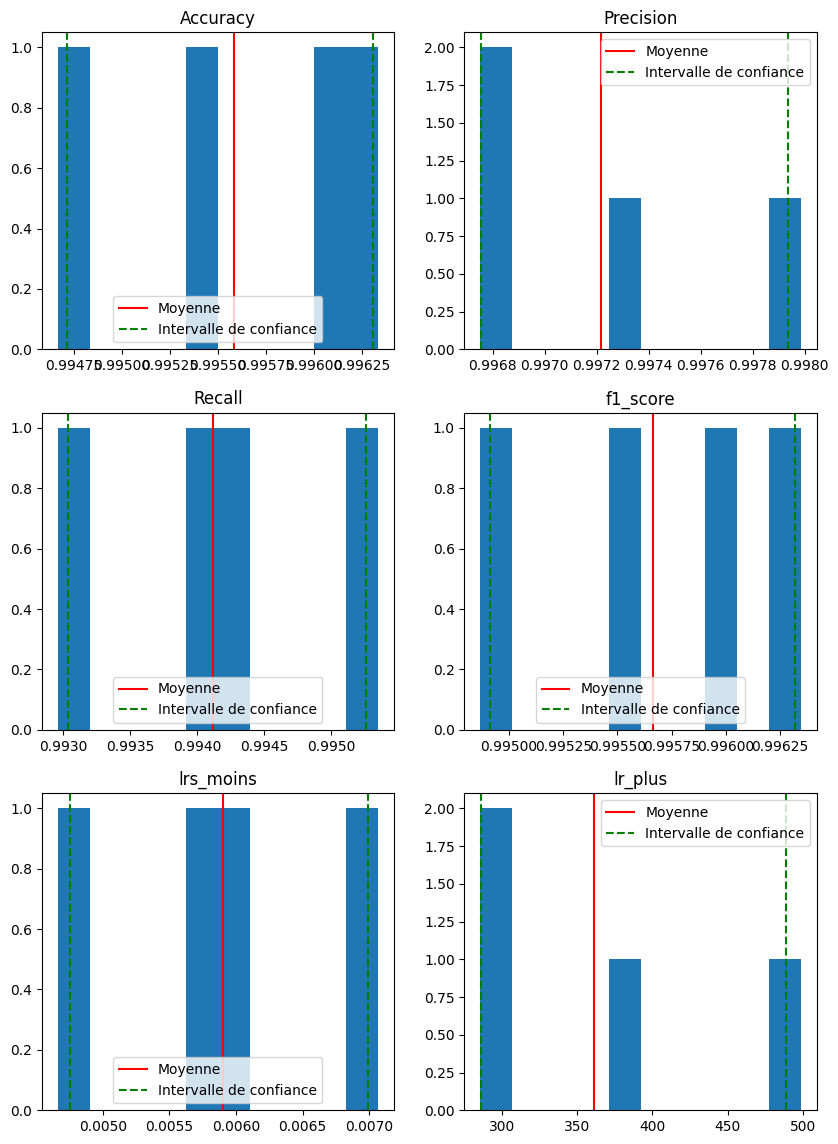

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(10,14))
axs = axs.ravel()

# métriques +scores
metrics = ['Accuracy','Precision','Recall','f1_score','lrs_moins','lr_plus']
scores = [accuracy_scores, precision_scores, recall_scores,f1_scores,lrs_moins,lrs_plus]

for i in range(len(metrics)):
    # calculer l'intervalle de confiance à 95 % pour chaque métrique
    conf_interval = np.percentile(scores[i], [2.5, 97.5])
    print(conf_interval[0],conf_interval[1])
    # tracer l'histogramme avec l'intervalle de confiance
    axs[i].hist(scores[i], bins=10)
   
    # Définir l'échelle de l'axe des abscisses
    axs[i].axvline(np.mean(scores[i]), color='red', label='Moyenne')
    axs[i].axvline(conf_interval[0], color='green', linestyle='--', label='Intervalle de confiance')
    axs[i].axvline(conf_interval[1], color='green', linestyle='--')
    axs[i].set_title(metrics[i])
    axs[i].legend()

# afficher le graphique
plt.show()

In [13]:
np.save("bootstrap_3000samples.npy",scores)

In [14]:
scores[0]

[0.9946666666666667, 0.9963333333333333, 0.996, 0.9953333333333333]